### Assignment 2

Deadline: 8 February.

**Question 1:** This question is about learning to use the VTK library. The idea is to implement a simple Grid class that allows to import triangle elements and vertices from vtk files and to export them to vtk files. The skeleton of the class is given as follows:

In [1]:
!conda install -c conda-forge --yes --verbose pyopencl pocl

Solving environment: ...working... done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.6.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/nbuser/anaconda3_501

  added / updated specs: 
    - pocl
    - pyopencl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    llvmdev-6.0.1              |    h6bb024c_1002       155.0 MB  conda-forge
    clangdev-6.0.1             |    h6c845d6_1000       110.1 MB  conda-forge
    llvm-meta-6.0.1            |                0           2 KB  conda-forge
    pytools-2019.1             |             py_0          49 KB  conda-forge
    libhwloc-2.0.2             |    h6c845d6_1000         2.6 MB  conda-forge
    conda-4.6.3                |           py36_0         872 KB  conda-forge
    pyopencl-2018.2.2          |py36h21

In [ ]:
!conda install -c anaconda --yes vtk

Solving environment: / 

In [7]:
class Grid(object):
    """This class implements access to triangular grids."""

    def __init__(self, vertices, elements):
        """
        Initialize a grid.

        This routine takes an Nx2 Numpy array of N vertices
        and a Mx3 Numpy array with corresponding M elements.
        """
        import numpy as np

        if not (isinstance(vertices, np.ndarray) and
                isinstance(elements, np.ndarray)):
            raise ValueError("The input data must be of type numpy.ndarray.")
        self.__vertices = vertices
        self.__elements = elements

        # Some protection against modifying the grid data externally
        self.__vertices.setflags(write=False)
        self.__elements.setflags(write=False)


    @classmethod
    def from_vtk_file(cls, filename):
        """Create a grid from a given vtk file."""

        # Insert code that reads a grid from a vtk file.
        # For this you should look up the VtkUnstructuredGridReader class.
        # Make sure that you only import triangular elements (check the vtk cell type).
        # VTK only knows vertices in 3 dimensions. Simply ignore the z-coordinate.
        
        # Below is a possible stub
        
        # import os.path
        # import vtk
        # import numpy as np

        # if not os.path.isfile(filename):
          #   raise ValueError("File does not exist.")

        # return cls(points, elements)
        
        import os.path
        import vtk
        import numpy as np

        filename = os.path.join(os.getcwd(), 'lshape.vtk')
        if not os.path.isfile(filename):
            raise ValueError("File does not exist.")

        reader = vtk.vtkUnstructuredGridReader()
        reader.SetFileName(filename)
        reader.Update()
        data = reader.GetOutput()
        point_data = data.GetPoints()
        number_of_points = point_data.GetNumberOfPoints()
        points = np.zeros((number_of_points, 3))
        
        for index in range(number_of_points):
            points[index, :] = point_data.GetPoint(index)
        number_of_cells = data.GetNumberOfCells()
        elements = []
        
        for index in range(number_of_cells):
            cell = data.GetCell(index)
            if cell.GetCellType() == vtk.VTK_TRIANGLE:
                elements.append(
                    [cell.GetPointId(0),
                     cell.GetPointId(1),
                     cell.GetPointId(2)]
                )
        elements = np.array(elements)
        return cls(points, elements)

    @property
    def number_of_vertices(self):
        """Return the number of vertices."""
        return self.__vertices.shape[0]

    @property
    def number_of_elements(self):
        """Return the number of elements."""
        return self.__elements.shape[0]

    @property
    def vertices(self):
        """Return the vertices."""
        return self.__vertices

    @property
    def elements(self):
        """Return the elements."""
        return self.__elements

    def get_corners(self, element_id):
        """Return the 2x3 matrix of corners associated with an element."""
        import numpy as np
        
        corners = np.zeros((3,2), dtype = np.float64)
        element = self.__elements[element_id]

        corner_id = 0
        for i in element: 
            corners[corner_id] = (self.__vertices[i][0],
                                  self.__vertices[i][1]) 
            corner_id += 1 
        
        return corners

    def get_jacobian(self, element_id):
        """Return the jacobian associated with a given element id."""
        import numpy as np
        
        corners = self.get_corners(element_id)
        jacobian = np.vstack((corners[1]-corners[0],
                              corners[2]-corners[0]))
        
        return np.transpose(jacobian)
 
    def export_to_vtk(self, fname, point_data=None):
        """Export grid to a vtk file. Optionally also export point data."""
        from vtk import vtkUnstructuredGrid, vtkPointData, vtkDoubleArray, \
            vtkPoints, vtkUnstructuredGridWriter, VTK_TRIANGLE

        grid = vtkUnstructuredGrid()

        if point_data is not None:

            data = grid.GetPointData()
            scalar_data = vtkDoubleArray()
            scalar_data.SetNumberOfValues(len(point_data))
            for index, value in enumerate(point_data):
                scalar_data.SetValue(index, value)
            data.SetScalars(scalar_data)

        points = vtkPoints()
        points.SetNumberOfPoints(self.number_of_vertices)
        for index in range(self.number_of_vertices):
            points.InsertPoint(
                index,
                (self.vertices[index, 0], self.vertices[index, 1], 0))

        grid.SetPoints(points)

        for index in range(self.number_of_elements):
            grid.InsertNextCell(
                VTK_TRIANGLE, 3,
                [self.elements[index, 0], self.elements[index, 1],
                 self.elements[index, 2]]
            )

        writer = vtkUnstructuredGridWriter()
        writer.SetFileName(fname)
        writer.SetInputData(grid)
        writer.Write()

        return grid

Once you have implemented the grid class it is time to test it. For testing use the following commands.

In [8]:
grid = Grid.from_vtk_file('lshape.vtk')

In [9]:
print(grid.vertices[0])
print(grid.elements[50])
print(grid.get_corners(50))
print(grid.get_jacobian(50))

[-0.  0.  0.]
[494 212 502]
[[0.96875 0.71875]
 [0.9375  0.6875 ]
 [0.96875 0.65625]]
[[-0.03125  0.     ]
 [-0.03125 -0.0625 ]]


**Question 2:**

We want to implement a finite difference method for the wave equation $u_{tt} = c^2u_{xx}$ for $c=1$ and $(t, x) \in [0, 1]\times [0, 2]$. The boundary conditions are $u(0, x) = e^{-5(x-.5)^2}$ and $\frac{\partial}{\partial n} u = 0$ otherwise.
The method should simply use central difference discretizations in space and time.

Your implementation should be written in OpenCL. Below you find a simple Numpy implementation that can serve as a template. Produce a plot of your result to demonstrate correctness.

Elapsed time (s): 0.2090301513671875


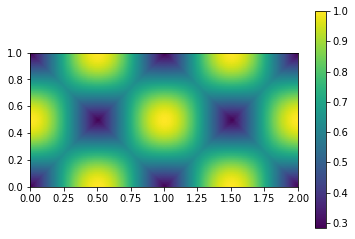

In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt


def solve_wave_equation(N, time_steps, c=1, T=1):
    """
    Solves a 1d wave equation.

    This function solves the 1d wave equation
    with zero boundary conditions. The x-domain is the
    interval [0, 1] and the final time is T.
    """

    xt_grid = np.zeros((N, time_steps + 1), dtype='float64')
    xx = np.linspace(0, 1, N)

    # Set initial condition
    xt_grid[:, 0] = np.exp(-5 * (xx-.5)**2)

    dt = T / (1.0 * time_steps)
    dx = 1. / (N - 1)

    # Compute courant number
    C = c * dt / dx
    # print("Courant Number: {0}".format(C))

    # Set first step

    for index in range(0, N):
        il = 1 if index == 0 else index - 1
        ir = N - 2 if index == N - 1 else index + 1
        xt_grid[index, 1] = xt_grid[index, 0] - \
            .5 * C**2 * (xt_grid[ir, 0] - 2 * xt_grid[index, 0]
                + xt_grid[il, 0])

    # Compute the other steps

    for t_index in range(1, time_steps ):
        for x_index in range(0, N):
            il = 1 if x_index == 0 else x_index - 1
            ir = N - 2 if x_index == N - 1 else x_index + 1
            xt_grid[x_index, t_index + 1] = \
                (- xt_grid[x_index, t_index - 1] + 2 * xt_grid[x_index, t_index] +
                 C**2 * (xt_grid[ir, t_index] -
                 2 * xt_grid[x_index, t_index] +
                 xt_grid[il, t_index]))

    return xt_grid

from time import time

T = 2
st = time()
res = solve_wave_equation(200, 500, c=1, T=T)
et = time()
print("Elapsed time (s): {0}".format(et - st))

plt.imshow(res, extent=[0, T, 0, 1])
plt.colorbar()
plt.show()


Elapsed time (s): 0.17161178588867188


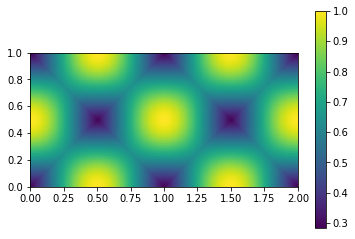

In [3]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import pyopencl as cl


def solve_wave_equation_opencl(N, time_steps, c=1, T=T):
    
    """Setting up the grid and initial conditions.
    These 3 steps are cheap (1.46 ms)(0.002% of total time)
    so wasn't worth it to re-write them in opencl 
    and deal with 2-dim data. Shown in Appenix at the end
    of the notebook."""  
    
    #===========Grid setup and initial conditions==
    grid = np.zeros([N, time_steps+1], dtype=np.double)
    xx = np.linspace(0, 1, N)
    grid[:, 0] = np.exp(-5 * (xx - .5) **2)
    
    #===========Calculate Courant number===========
    dt = T / (1.0 * time_steps)
    dx = 1. / (N - 1)
    C = c * dt / dx

    #===========Calculate the first steps==========
    """The cost of moving data from device would be 
    same/more than what could be saved (this small problem) 
    if I rewrote this in OpenCl in a separate kernel."""
    
    for XID in range(0, N):
        left  = 1 if XID  == 0 else XID  - 1
        right  = N - 2 if XID  == N - 1 else XID  + 1
        grid[XID, 1] = grid[XID, 0]-.5*C*C*(grid[right, 0] 
                       - 2* grid[XID, 0]+ grid[left, 0])
    #==============================================
    
    # kernel in OpenCL that does the heavy load for other steps
    solve_wave_kernel = """
    __kernel void solve_wave_equation(const int time_step,
                                      const double C,
                                      __global double* grid)
    
    {
        const int XID = get_global_id(0);      
        
        //---This is the main loop parallelised for spatial x
        
        grid[XID*t_i + time_step + 1] =
            -grid[XID * t_i + time_step - 1]
            +(2 * grid[XID * t_i + time_step]) 
            + C*C * (grid[(XID + 1) * t_i + time_step] 
            -(2 * grid[XID * t_i + time_step]) 
            + grid[(XID - 1) * t_i + time_step]);
            
            
        //---Applying the boundary conditions:
        //instead of having il,ir and going through if-else 
        //I just put the values inside for the main points(above)
        //and I do the corresponding with the two boundaery points
        //this way avoids complications of if-else for price of 
        //add operations which cost which is very cheap.
        
        
        if(XID == 0){grid[time_step + 1] = 
            -grid[time_step - 1] + 2 * grid[time_step]
            + 2*C*C * (grid[t_i + time_step] - grid[time_step]);  
        } 
        
        if(XID == x_i-1){grid[(x_i - 1) *t_i + time_step + 1] = 
            -grid[(XID - 1) * t_i + time_step - 1] 
            + 2 * grid[(XID - 1) * t_i + time_step]
            + 2*C*C* (grid[(XID - 2) * t_i + time_step]
            -grid[(XID - 1) * t_i + time_step]);
        }
        
    }
    """
    # Setting the contex and creating the program
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)

    prg = cl.Program(ctx, solve_wave_kernel)
    prg.build(options=['-D', 'x_i={0}'.format(grid.shape[0]),
                       '-D', 't_i={0}'.format(grid.shape[1])])
    wave_kernel = prg.solve_wave_equation
    
    # Setting the work-group size automatically 
    dev = ctx.devices[0]
    workGroup_size = wave_kernel.get_work_group_info(
         cl.kernel_work_group_info.PREFERRED_WORK_GROUP_SIZE_MULTIPLE, dev)
    
    mf = cl.mem_flags
    grid_buffer = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=grid)
    
    # Loops over the time. The kernel is parallelised for space.
    for t in range(1, time_steps):
        wave_kernel(queue, (N, 1), (workGroup_size, 1), 
                    np.int32(t), np.double(C),  grid_buffer)

        grid, _ = cl.enqueue_map_buffer(queue, grid_buffer,
                        cl.map_flags.READ, 0, grid.shape, np.double)
    return grid


from time import time

T = 2
st = time()
res = solve_wave_equation_opencl(200, 500, c=1, T=T)
et = time()
print("Elapsed time (s): {0}".format(et - st))

plt.imshow(res, extent=[0, T, 0, 1])
plt.colorbar()
plt.show()


# Comparing speeds: I get ~2/3 the speed of the python code. 

Elapsed time (s): 0.17275285720825195


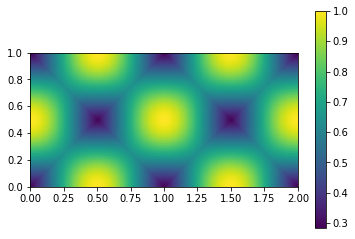

140 ms ± 2.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
210 ms ± 3.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
from time import time

T = 2
st = time()
res = solve_wave_equation_opencl(200, 500, c=1, T=T)
et = time()
print("Elapsed time (s): {0}".format(et - st))

plt.imshow(res, extent=[0, T, 0, 1])
plt.colorbar()
plt.show()

%timeit   solve_wave_equation_opencl(200, 500, c=1, T=T)
%timeit   solve_wave_equation(200,500,c=1,T=T)

# Appendix: Showing the Cheapness of the initial steps in python

In [6]:
def initial(N, time_steps, T=2, c=1):   
    xt_grid = np.zeros([N, time_steps+1], dtype=np.double)
    xInit = np.linspace(0, 1, N)
    xt_grid[:, 0] = np.exp(-5 * (xInit - .5) **2)
    
    #===========Calculate Courant number===========
    dt = T / (1.0 * time_steps)
    dx = 1. / (N - 1)
    C = c * dt / dx

    #===========Calculate the first steps===========

    for XID in range(0, N):
        left  = 1 if XID  == 0 else XID  - 1
        right  = N - 2 if XID  == N - 1 else XID  + 1
        xt_grid[XID, 1] = xt_grid[XID, 0]-.5*C*C*(xt_grid[right, 0] 
                       - 2* xt_grid[XID, 0]+ xt_grid[left, 0])
        

%timeit initial(200,500,2,1)
%timeit solve_wave_equation(200,500,c=1,T=T)

412 µs ± 9.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
206 ms ± 7.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
